In [1]:
############
# Imports #

import torch
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import rasterio
import numpy as np
from torchvision import models, transforms
from utils import ImageDataset, SaveFeatures, accuracy, imshow_transform
from VGG_16bn import vgg16bn
from torch.autograd import Variable
import matplotlib.pyplot as plt 


###################
# Hyperparameters #

n_samples = 3000
n_samples_train = int(round(n_samples*0.8))
batch_size = 20
current_computer = "ubuntu" # "macbook"
layers_to_freeze = 30
lr = 0.00001
weight_decay=0.08
num_epochs = 20
im_size = 200


#############
# Load data #

if current_computer == "ubuntu":
    image_dir = f"/home/nadjaflechner/Palsa_data/dataset_{im_size}m/"
    labels_file = f"/home/nadjaflechner/Palsa_data/binary_palsa_labels_{im_size}m.csv"
elif current_computer == "macbook":
    image_dir = f"/Users/nadja/Documents/UU/Thesis/Data/{im_size}m"
    labels_file = f"/Users/nadja/Documents/UU/Thesis/Data/{im_size}m_palsa_labels.csv"

# Load the labels from the CSV file
labels_df = pd.read_csv(labels_file, index_col=0).head(n_samples)

# Split the dataset into training and validation sets
train_df = labels_df.head(n_samples_train)
val_df = labels_df.drop(train_df.index)

# Create the datasets and data loaders
train_dataset = ImageDataset(image_dir, train_df )
val_dataset = ImageDataset(image_dir, val_df)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [2]:
################
# Define model #

model = vgg16bn()

#freeze layers
for idx, param in enumerate(model.parameters()):
    if idx == layers_to_freeze:
        break
    param.requires_grad = False

#modify the last two convolutions
model.features[-7] = nn.Conv2d(512,512,3, padding=1)
model.features[-4] = nn.Conv2d(512,2,3, padding=1)
model.features[-3] = nn.BatchNorm2d(2,eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

#remove fully connected layer and replace it with AdaptiveAvePooling
model.classifier = nn.Sequential(
                                nn.AdaptiveAvgPool2d(1),
                                nn.Flatten()
                                )

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
loss_function = nn.CrossEntropyLoss()

In [3]:
##################
# Training loop #

# adapted from https://github.com/tony-mtz/CAM/blob/master/network/net.py

weights = models.VGG16_BN_Weights.DEFAULT
transforms = weights.transforms()

mean_train_losses = []
mean_val_losses = []

mean_train_acc = []
mean_val_acc = []


for epoch in range(num_epochs):
    print('EPOCH: ',epoch+1)

    train_acc = []
    val_acc = []
    running_loss = 0.0
        
    model.train()
    count = 0
    for batch_idx, (images, labels) in enumerate(train_loader):     

        # load images and labels 
        images = Variable(transforms(images)).to(device)
        labels = Variable(labels.long()).to(device)

        # train batch   
        outputs = model(images)         
        optimizer.zero_grad()
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()  

        # calculate loss and accuracy
        batch_accuracy = accuracy(outputs, labels.long())
        train_acc.append(batch_accuracy)

        running_loss += loss.item()
        count += 1
    
    mean_train_losses.append(running_loss/count)
        
    model.eval()
    count = 0
    val_running_loss = 0.0
    model.to(device)

    for batch_idx, (images, labels) in enumerate(val_loader):     
        # inference   
        images = Variable(transforms(images)).to(device)
        labels = Variable(labels.long()).to(device)
        outputs = model(images)
        loss = loss_function(outputs, labels)

        val_acc.append(accuracy(outputs, labels))
        val_running_loss += loss.item()
        count +=1

    # update losses and accuracies 
    mean_val_loss = val_running_loss/count  
    mean_val_losses.append(mean_val_loss)
    mean_train_acc.append(np.mean(train_acc))
    val_acc_ = np.mean(val_acc)
    mean_val_acc.append(val_acc_)

EPOCH:  1


/home/nadjaflechner/miniconda3/envs/torch_only_env/lib/python3.12/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


EPOCH:  2
EPOCH:  3
EPOCH:  4
EPOCH:  5
EPOCH:  6
EPOCH:  7
EPOCH:  8
EPOCH:  9
EPOCH:  10
EPOCH:  11
EPOCH:  12
EPOCH:  13
EPOCH:  14
EPOCH:  15
EPOCH:  16
EPOCH:  17
EPOCH:  18
EPOCH:  19
EPOCH:  20


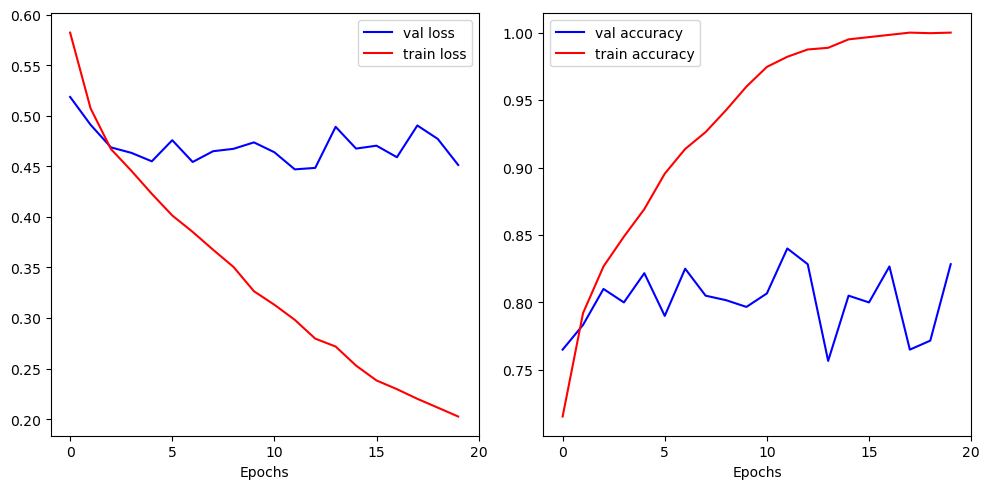

In [5]:
##########################
# plot loss and accuracy #

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))

ax1.plot([i for i in range(num_epochs)], mean_val_losses, c = 'b', label = 'val loss')
ax1.plot([i for i in range(num_epochs)], mean_train_losses, c = 'r', label = 'train loss')
ax1.set_xlabel("Epochs")
ax1.set_xticks(range(0,num_epochs+1,5))
ax1.legend()

ax2.plot([i for i in range(num_epochs)], mean_val_acc, c = 'b', label = 'val accuracy')
ax2.plot([i for i in range(num_epochs)], mean_train_acc, c = 'r', label = 'train accuracy')
ax2.set_xlabel("Epochs")
ax2.set_xticks(range(0,num_epochs+1,5))
ax2.legend()

plt.tight_layout()
plt.show()

In [6]:
####################
# generating CAMs #

from torch.autograd import Variable
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from skimage.transform import resize
from skimage.io import imshow

#change batch size to 1 to grab one image at a time
valid_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, 
                                          shuffle=True,
                                          num_workers=1)

#get the last convolution
sf = SaveFeatures(model.features[-4])

In [7]:
#get image and label
im, lab = next(iter(valid_loader))

im = Variable(im).to(device)
lab = Variable(lab).to(device)

outputs = model(transforms(im)).to(device)
res = torch.argmax(outputs.data).cpu().detach().numpy()

if res==1:
    print('result: palsa',res)
else:
    print('result: no palsa',res)

result: palsa 1


/home/nadjaflechner/miniconda3/envs/torch_only_env/lib/python3.12/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


<Figure size 640x480 with 0 Axes>

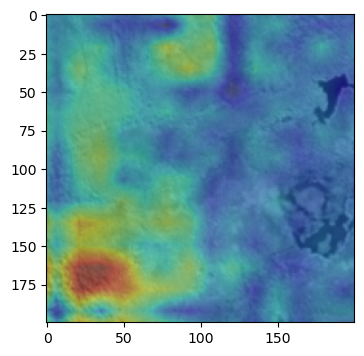

In [8]:
# generate CAM
sf.remove()
arr = sf.features.cpu().detach().numpy()
arr1 = arr[0]
ans_nopalsa = np.dot(np.rollaxis(arr1,0,3), [1,0])
ans_palsa = np.dot(np.rollaxis(arr1,0,3), [0,1])

if res==1:
    CAM = resize(ans_palsa, (200,200))
else:
    CAM = resize(ans_nopalsa, (200,200))

# Plot image with CAM
cpu_img = im.squeeze().cpu().detach().permute(1,2,0).long().numpy()

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))

ax1.imshow(cpu_img)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('original image')

ax2.imshow(cpu_img)
ax2.imshow(CAM, alpha=.4, cmap='jet')
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title('image with CAM')

plt.tight_layout()
plt.show()